In [29]:
import numpy as np
import scipy.cluster 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise H7.1: Training data

## (a) Input Samples

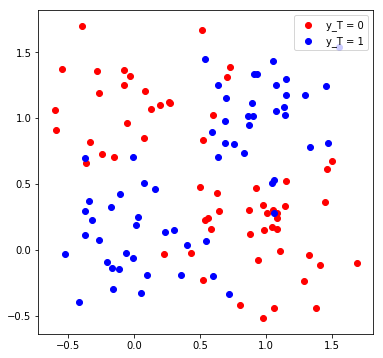

In [276]:
def SampleMixtureNormal2D(m1, s1, m2, s2): # m1, m2 are the means, s1, s2 the variances (same for all components)
    if (np.random.choice([0,1])):
        return np.random.multivariate_normal(m1, [[s1, 0], [0, s1]])
    else:
        return np.random.multivariate_normal(m2, [[s2, 0], [0, s2]])


def getSamples(m1, m2, m3, m4, s, N = 0, M = 0):
    
    samples = np.zeros((N + M, 2))
    classes = np.zeros((N + M, 2))
    
    for i in range(N):
        samples[i] = SampleMixtureNormal2D(m1, s, m2, s)
        classes[i] = np.array([1,0])
    for i in range(M):
        samples[i + N] = SampleMixtureNormal2D(m3, s, m4, s)
        classes[i + N] = np.array([0,1])
        
    return samples, classes

samples, classes = getSamples([0, 1], [1, 0], [0, 0], [1, 1], 0.1, 60, 60)

def getClassColor(i):
    colors = [(1,0,0),(0,0,1),(0,1,0),(1,1,0),(1,0,1),(0,1,1)]
    return colors[i%6]

def plotSamples(ax, samples, classes):
    
    K = classes.shape[1]

    handles = [None] * K
    
    for k in range(K):
        c = samples[np.where(classes[:,k] == 1)]
        handles[k] = ax.scatter(c[:,0],c[:,1], c = getClassColor(k), label='y_T = '  + str(k))
        
    ax.set_aspect('equal')
    ax.legend(handles = [y_0, y_1])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plotSamples(ax, samples, classes)


# Exercise H7.2: k nearest neighbors (kNN)

## (a) Patterns and decision boundary

In [303]:
def plotClassifier(x, y, probabilities, samples, classes, title):
    
    K = classes.shape[1]
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    plotSamples(ax, samples, classes)
    
    # plot decision boundary
    n = probabilities.shape[0]
    m = probabilities.shape[1]
    
    min_x, max_x = samples[:,0].min() - 0.1, samples[:,0].max() + 0.1
    min_y, max_y = samples[:,1].min() - 0.1, samples[:,1].max() + 0.1 
    
    image = np.zeros((n, m, 3))
    for i in range(n):
        for j in range(m):
            c = getClassColor(np.argmax(probabilities[j,n-1-i]))
            image[i,j, :] = np.array([c[0]*0.7, c[1]*0.7, c[2]*0.7])      
            #image[i,j, :] = np.array([j/m, 0, 0])     
    ax.imshow(image, extent = (min_x,max_x,min_y,max_y))
    ax.set_title(title)
    
    return ax

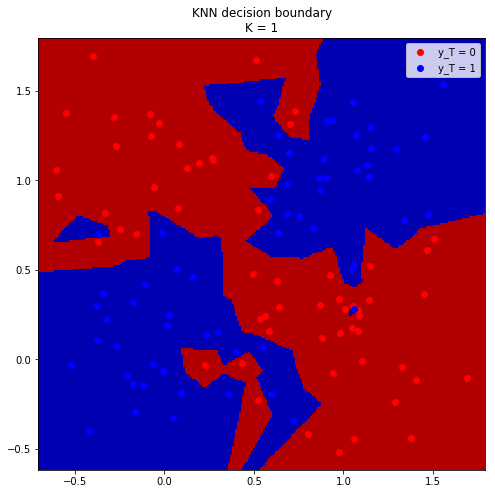

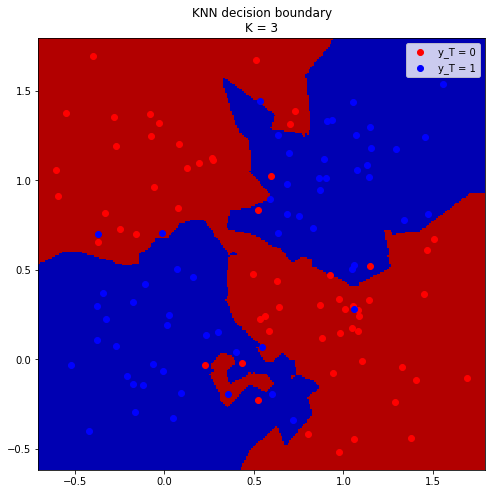

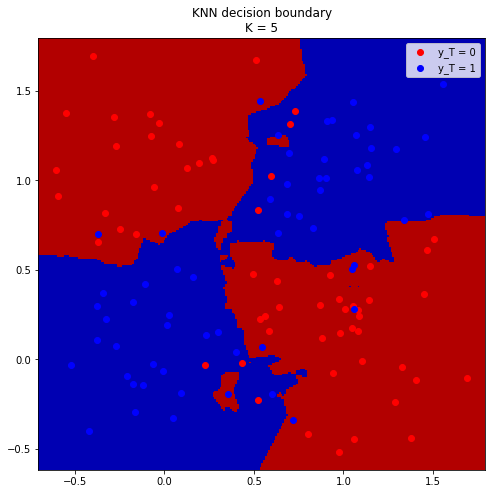

In [304]:
def getKNNClassProb(x, k, samples, classes):
    m = np.subtract(samples, x)
    d = np.sum(np.multiply(m,m), axis = 1)
    return np.average(classes[d.argsort()[:k]], axis = 0)

def getKNNClassProbabilities(x, y, k, samples, classes):
    n = x.size
    m = y.size
    probs = np.zeros((n,m,classes.shape[1]))
    for i in range(n):
        for j in range(m):
            probs[i,j,:] = getKNNClassProb([x[i], y[j]], k, samples, classes)
    return probs

def getGrid(res, samples):  
    min_x, max_x = samples[:,0].min() - 0.1, samples[:,0].max() + 0.1
    min_y, max_y = samples[:,1].min() - 0.1, samples[:,1].max() + 0.1 
    return np.linspace(min_x, max_x, res), np.linspace(min_y, max_y, res) 

x, y = getGrid(256, samples)  

for K in [1,3,5]:
    probs = getKNNClassProbabilities(x, y, K, samples, classes)
    plotClassifier(x, y, probs, samples, classes, 'KNN decision boundary\nK = ' + str(K))
    

With increasing K, the model becomes more robust against outliers but sometimes we can observer small artifacts which are probably not desirable. Also with increasing K, the decision boundary becomes more of an average and does not extend to points which are in the neighbourhood of points of a different class. This sometimes does not seem reasonable.

# Exercise H7.3: “Parzen window” classifier

## (a) Training patterns and the decision boundary

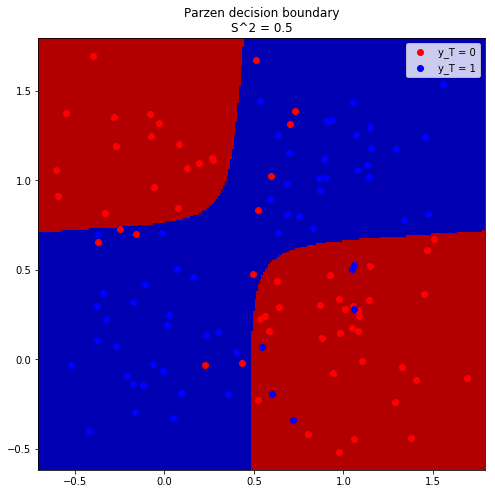

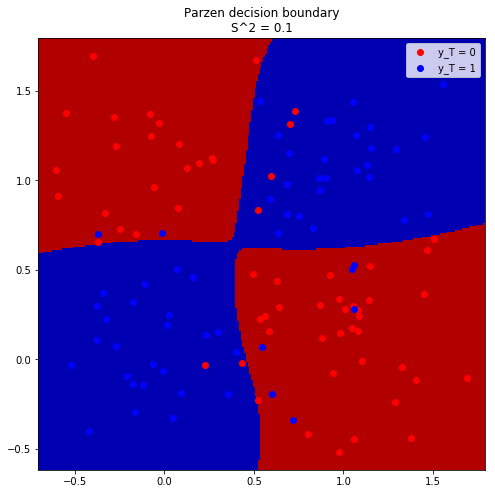

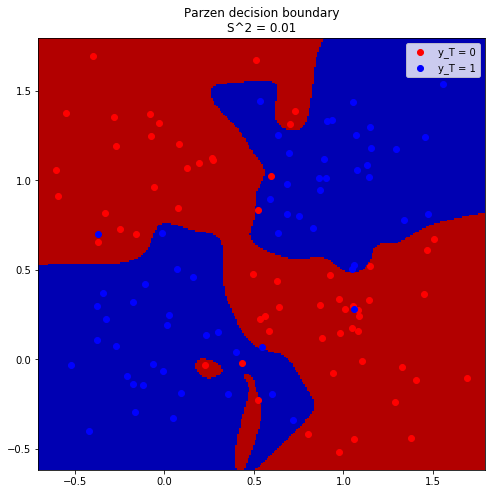

In [298]:
def getParzenClassProb(x, s, samples, classes):
    m = np.subtract(samples[:,0:2],x) # help array
    d = np.sum(np.multiply(m,m), axis = 1) # distance between x and every point in samples
    w = np.exp(np.multiply(- 1 / (2*s), d)) # weight for every point in samples
    return np.divide(np.sum(np.multiply(classes, w[:,None]), axis = 0), np.sum(w))
    
def getParzenClassProbablities(x, y, s, samples, classes):
    n = x.size
    m = y.size
    probs = np.zeros((n,m,classes.shape[1]))
    for i in range(n):
        for j in range(m):
            probs[i,j,:] = getParzenClassProb([x[i], y[j]], s, samples, classes)
    return probs

x, y = getGrid(256, samples)                     
                     
for S in [0.5, 0.1, 0.01]:
    probs = getParzenClassProbablities(x, y, S, samples, classes)
    plotClassifier(x, y, probs, samples, classes, 'Parzen decision boundary\nS^2 = ' + str(S))


## (b) 60 more data points

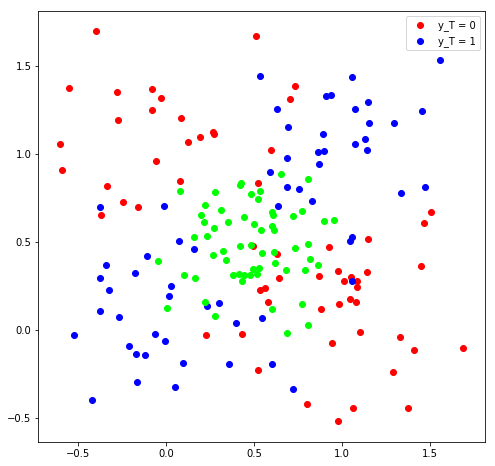

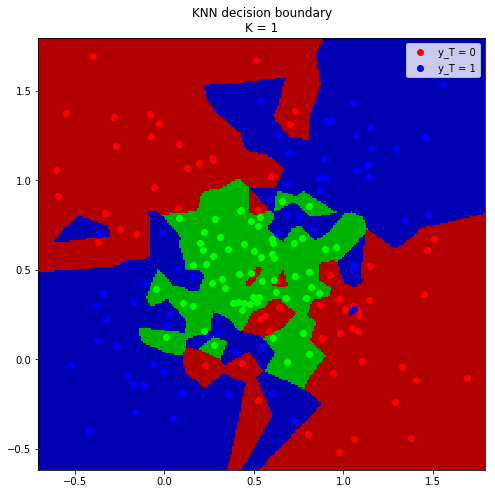

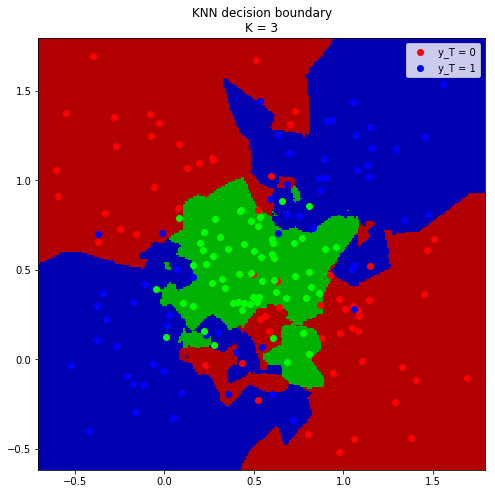

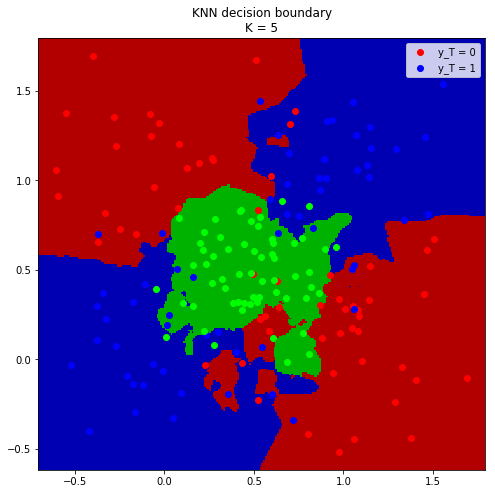

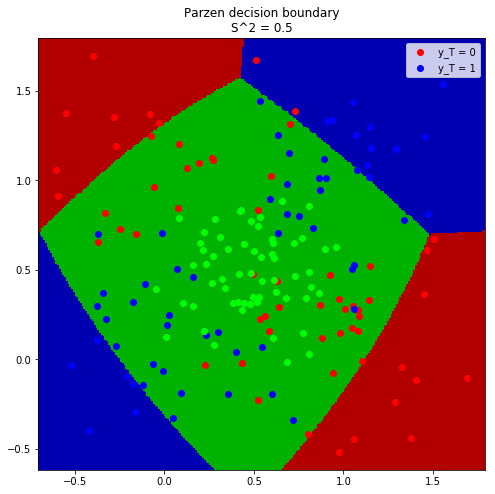

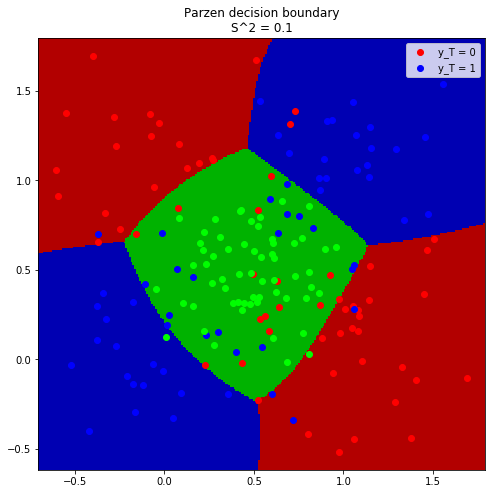

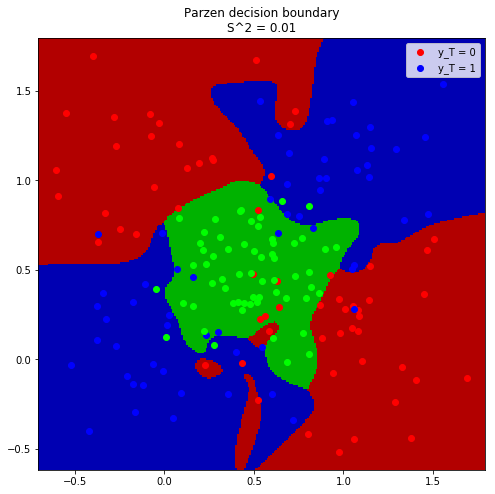

In [299]:
# generating points for 3rd class:
samples_3 = np.zeros((60,2))
classes_3 = np.zeros((60,3))

for i in range(60):
    samples_3[i] = np.random.multivariate_normal([0.5, 0.5], [[0.05, 0], [0, 0.05]])
    classes_3[i] = np.array([0,0,1])

# add new samples                                                 
ex_samples = np.append(samples, samples_3, axis = 0)
                                                 
# add new classes      
ex_classes = np.append(classes, np.zeros((classes.shape[0],1)), axis = 1) # add new class option
ex_classes = np.append(ex_classes, classes_3, axis = 0)                                   

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plotSamples(ax, ex_samples, ex_classes)

x, y = getGrid(256, samples)                     
  
for K in [1,3,5]:
    probs = getKNNClassProbabilities(x, y, K, ex_samples, ex_classes)
    plotClassifier(x, y, probs, ex_samples, ex_classes, 'KNN decision boundary\nK = ' + str(K))                   
for S in [0.5, 0.1, 0.01]:
    probs = getParzenClassProbablities(x, y, S, ex_samples, ex_classes)
    plotClassifier(x, y, probs, ex_samples, ex_classes, 'Parzen decision boundary\nS^2 = ' + str(S))

# Exercise H7.4: RBF networks

##  (a) Decision boundaries and training patterns

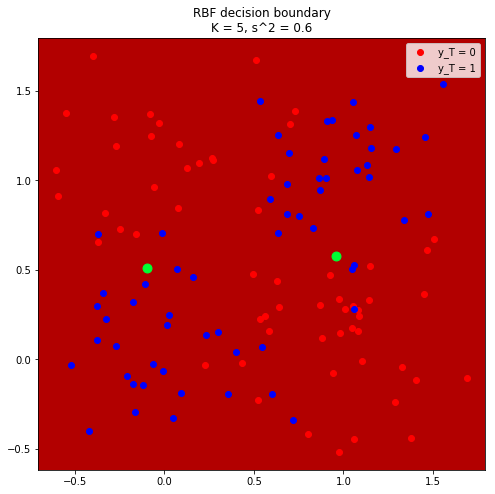

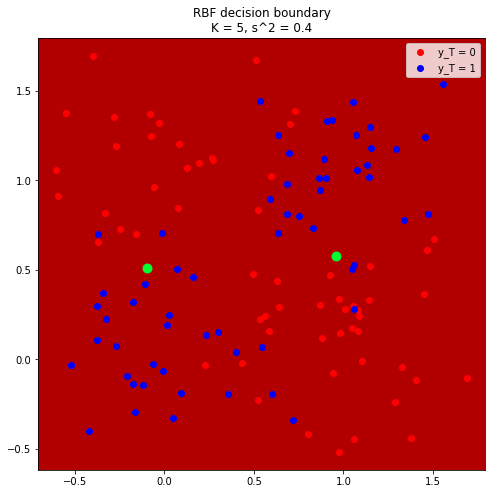

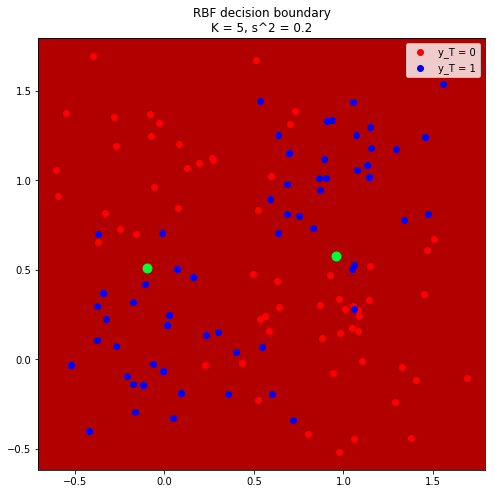

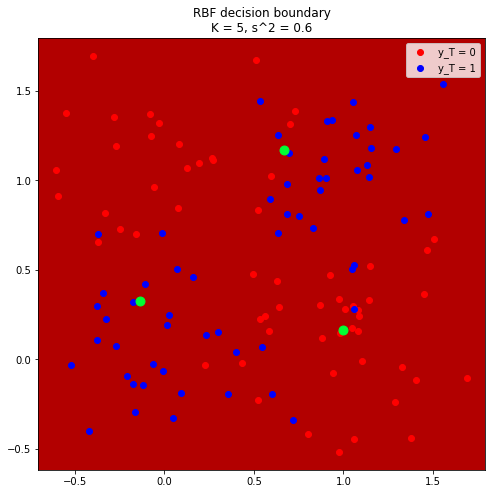

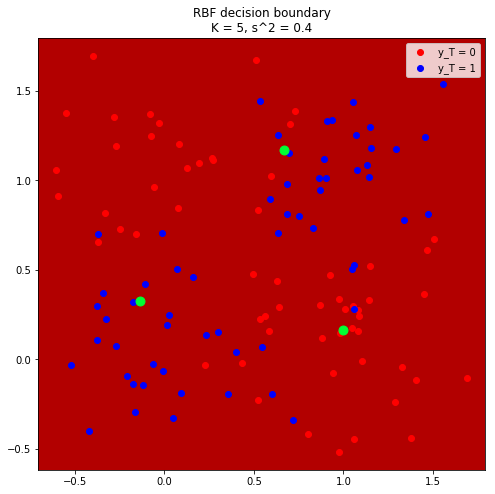

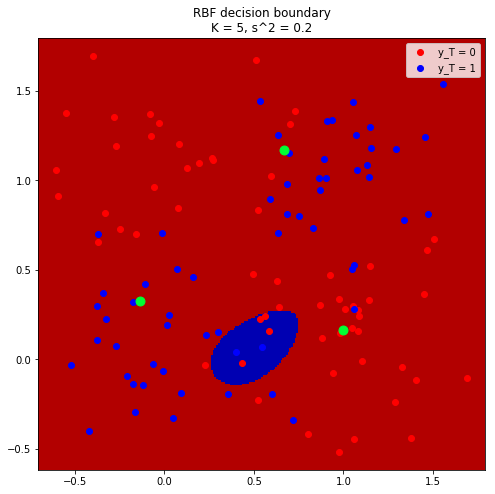

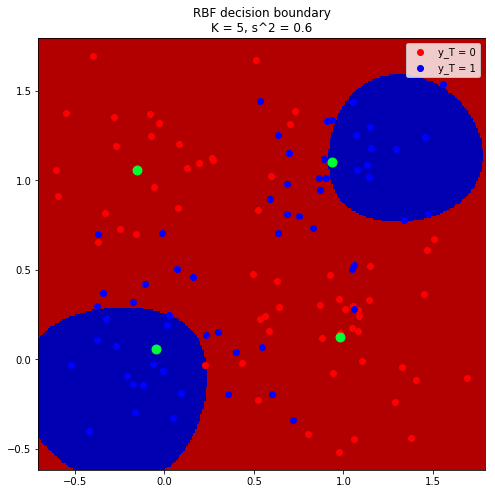

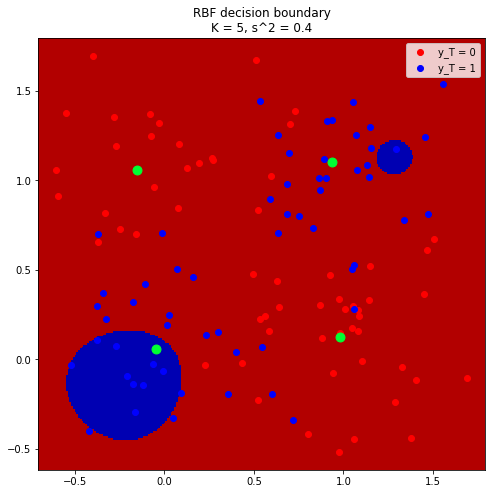

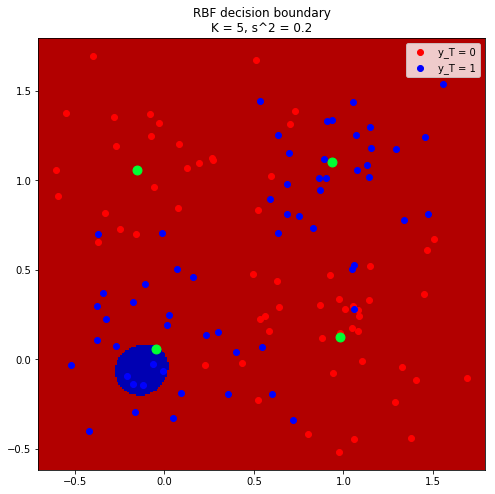

In [317]:
def getKMeans(k, samples):
    return scipy.cluster.vq.kmeans(samples, k)[0]

def sign(h):
    if (h>= 0):
        return 1
    else:
        return 0
    #return h   # <-- this works quite well
    
def getWeight(T, s, samples, classes): # T - representives, s - RBF variance 
    
    yT = classes[:,0]
    X = samples
    
    # calculate the RBF function values
    A = T[:,None,:] - X[None,:,:]
    A = np.sum(A * A, axis = 2)
    A = np.multiply(- 1 / (2 * s), A)
    A = np.exp(A)
    
    # add bias
    Phi = np.lib.pad(A, ((1,0),(0,0)), 'constant', constant_values=1)
    
    return np.dot(np.dot(np.linalg.inv(np.dot(Phi, Phi.T)), Phi), yT)

def getphi(T, s, x):
    
    A = T - x
    A = np.sum(A * A, axis = 1)
    A = np.multiply(- 1 / (2 * s), A)
    A = np.exp(A)
    
    return np.append([1], A)

def RBFPrediction(T, s, w, x):
    return sign(np.dot(w.T, getphi(T, s, x)))
    #return np.dot(w.T, getphi(T, s, x))
    
def getRBFClassProbabilities(x, y, T, s, w):
    n = x.size
    m = y.size
    probs = np.zeros((n,m,2))
    for i in range(m):
        for j in range(n):
            probs[i,j,0] = RBFPrediction(T, s, w, [x[j], y[i]])
            probs[i,j,1] = 1 - probs[i,j,0]
            
    return probs

x, y = getGrid(256, samples)  

for k in [2,3,4]:
    T = getKMeans(k, samples)
    for s in [0.6,0.4, 0.2]:
        w = getWeight(T, s, samples, classes)
        probs = getRBFClassProbabilities(x, y, T, 0.4, w)
        ax = plotClassifier(x, y, probs, samples, classes, 'RBF decision boundary\nK = ' + str(K) + ', s^2 = ' + str(s))
        ax.scatter(T[:,0],T[:,1],c='#00ff33', s=80)
    

## (b) RBF-network with 2 RBFs